In [1]:
import numpy as np
import pandas as pd

from taylor_diagram import TaylorDiagram

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from statistics import stdev
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error


def result_dataframe(path, dataset_name, actual=False):

    model_directories = glob(path + f"/{dataset_name}/*/")

    table_dict = {}

    for idx in range(len(model_directories)):
        directory = model_directories[idx]
        model_name = directory.split("/")[-2]       
        station_pkls = glob(path + f"/{dataset_name}/" + model_name + "/*_pm25.pkl")
        
        if model_name == 'TSTransformer':
            model_name = 'PolTrans'
        
        if actual == True :
            model_name = "Actual"

        model_data = {}
        for inner_idx in range(len(station_pkls)):
            station_data = pickle.load(open(station_pkls[inner_idx], "rb"))
            station_data['score'] = {}
            
            if actual == True : 
                station_data['test_set_predictions'] = station_data['test_set']
            
            station_data['score']['stddev'] = stdev(station_data['test_set_predictions'].flatten())            
            station_data['score']['ccoef'] = pearsonr(station_data['test_set'].reshape(-1),
                                                      station_data['test_set_predictions'].reshape(-1))[0]
            station_data['score']['crmsd'] = np.sqrt(mean_squared_error(station_data['test_set'], 
                                                                station_data['test_set_predictions']))
            
            model_data[station_data["station_id"]] = station_data["score"]
            
        table_dict[model_name] = model_data

    reform = {(outerKey, innerKey): values for outerKey, innerDict in table_dict.items() for innerKey, values in innerDict.items()}

    result_df = pd.DataFrame(reform).transpose()
    
    return result_df

In [4]:
from glob import glob
import pickle

path = "./stat_models"
dataset_directories = glob(path + f"/*/")

result_df_list = []

for ds_dir in dataset_directories:
    dataset_name = ds_dir.split("/")[-2]
    result_df = result_dataframe(path, dataset_name)    
    result_df_list.append([dataset_name, result_df])

In [5]:
path = "./tstrans_models"
dataset_directories = glob(path + f"/*/")

for idx, ds_dir in enumerate(dataset_directories):
    dataset_name = ds_dir.split("/")[-2]
    result_df = result_dataframe(path, dataset_name)    
    result_df_list[idx][1] = pd.concat([result_df_list[idx][1], result_df], axis=0)
    result_df = result_dataframe(path, dataset_name, actual=True) 
    result_df_list[idx][1] = pd.concat([result_df, result_df_list[idx][1]], axis=0)

In [6]:
import copy
processed_result_df_list = copy.deepcopy(result_df_list)

for idx, (city, df) in enumerate(processed_result_df_list):
    new_df = pd.DataFrame()
    for col in ['stddev', 'ccoef', 'crmsd']:
        new_df = pd.concat([new_df, df[[col]].mean(axis=0, level=0)], axis=1)
    processed_result_df_list[idx][1] = new_df

processed_result_df_list.sort(key=lambda x:x[0])

In [7]:
import matplotlib.pyplot as plt

def get_taylor_diagram_plot(df, fig, legend):

    stddev = df['stddev'].values
    ccoef  = df['ccoef'].values
    crmsd  = df['crmsd'].values
    label  = list(df.index.values)

    dia = TaylorDiagram(stddev[0], 
                        fig=fig, 
                        label="Actual",
                        srange=(0, 1.5))
    
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    for i in range(1, len(stddev)):
        dia.add_sample(stddev[i], ccoef[i],
                       marker='o', ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=label[i],
                       zorder=i+2)
    
    dia.add_grid()
    
    contours = dia.add_contours(colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    if legend:
        fig.legend(dia.samplePoints,
                   [p.get_label() for p in dia.samplePoints],
                   numpoints=1, prop=dict(size='small'), loc='upper right')

In [8]:
plt.rcParams["font.size"] = 14

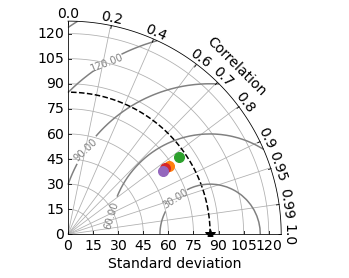

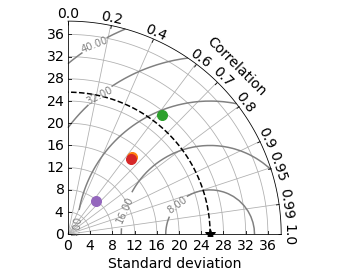

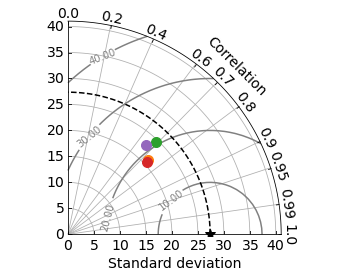

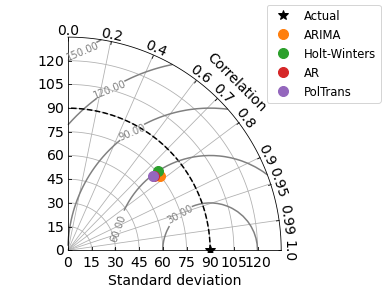

In [9]:
import string

for idx, (city, df) in enumerate(processed_result_df_list):
    fig = plt.figure(figsize=(6, 4))
    legend = (idx == len(processed_result_df_list)-1)
    get_taylor_diagram_plot(df, fig, legend=legend)
    plt.savefig(f"./paper_figures/taylor-diag-stat-{city}.png", dpi=400, bbox_inches='tight')

In [10]:
import string

def plot_in_img(ax, img, n, city):
    ax.imshow(img)
    ax.axis('off')
    ax.text(0.35, -0.05, f"({string.ascii_lowercase[n]}) {city}", transform=ax.transAxes, 
            size=22, weight='bold')

In [11]:
plt.rcParams["font.family"] = "Times New Roman"

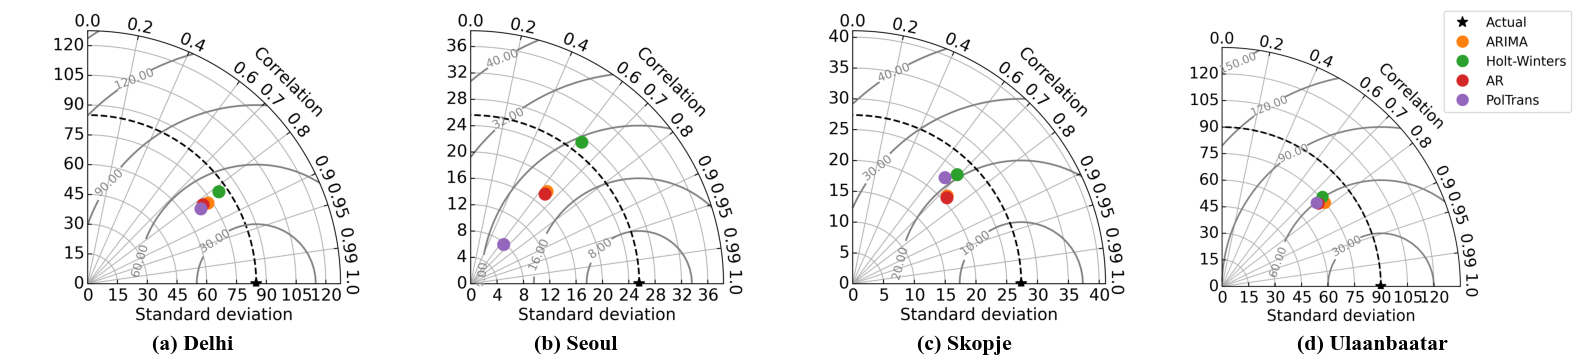

In [12]:
cities = [x[0] for x in processed_result_df_list]
fig, axs = plt.subplots(1, 4, figsize=(32, 6))

for idx, city in enumerate(cities):
    file_name = "./paper_figures/" + f"taylor-diag-stat-{city}.png"
    img = plt.imread(file_name)
    ax = axs[idx%4]
    plot_in_img(ax, img, idx, city.capitalize());  

plt.subplots_adjust(wspace=-0.4)
plt.savefig(f"./paper_figures/merged_taylor_stat.png", bbox_inches="tight", dpi=400)